cwd:      c:/usp/usehpsj/study/textbook/DlPytorch/code/RnnLearn/04_crnnIamHwTextLine/src
projRoot: c:/usp/usehpsj/study/textbook/DlPytorch/code/RnnLearn/04_crnnIamHwTextLine



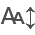

12

In [ ]:
import re

import time
from datetime import datetime

import random

from pathlib import Path
import os
import sys
import glob
from io import StringIO

from enum import Enum
from dataclasses import dataclass
from typing import TypedDict, Callable

import warnings
import traceback

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from PIL import Image
from PIL import ImageOps

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import torch
from torch import Tensor
from torch import optim
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torchvision.models import resnet18


from IPython.display import display, HTML, Math, Latex
from IPython.core.getipython import get_ipython

import multiprocessing as mp

from tqdm.notebook import tqdm

################
# torch.set_default_dtype(torch.float32)

################
# %matplotlib inline

get_ipython().ast_node_interactivity = "all"  # 'last_expr' # pyright: ignore[reportOptionalMemberAccess]

np.set_printoptions(edgeitems=5, precision=3, suppress=True, linewidth=160, threshold=50)
torch.set_printoptions(edgeitems=5, precision=3, sci_mode=False, linewidth=160, threshold=50)

plt.rcParams['figure.figsize'] = (2, 2)
# display(HTML("<style>img { max-width: 10%; max-height: 10%; }</style>"))
# imgWidth = 100
# imgHeight = 100

seedMain = 42
# np.random.seed(42)
rng = np.random.default_rng(42)  # https://blog.scientific-python.org/numpy/numpy-rng/

_ = torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)  # For all devices

################
# %load_ext autoreload
# %autoreload 2
import importlib

################
path_cwd = Path.cwd()
print("cwd:      " + path_cwd.as_posix())
path_GrandProjectRoot = path_cwd.parent.parent.absolute()
path_ProjectRoot = path_cwd.parent.absolute()
print("projRoot: " + path_ProjectRoot.as_posix())
sys.path.append(path_ProjectRoot.as_posix())
################
from src.config.itables import itables
from src.config.itables.itables import ItablesConfig

# _ = importlib.reload(itables)
ItablesConfig.init()
################
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
display(device)
cpu_count = mp.cpu_count()
display(cpu_count)

### @setup

In [2]:
# // @todo 
# 1. add attention mechanism 
# 1. add word embeddding
#  

In [3]:
# Deep-Learning-Projects.pytorch/5-Captcha-Text-Recognition-With-CRNN.ipynb at master · gokulkarthik/Deep-Learning-Projects.pytorch
# https://www.kaggle.com/code/gokulkarthik/captcha-text-recognition-using-crnn-in-pytorch/output
# https://github.com/gokulkarthik/Deep-Learning-Projects.pytorch/blob/master/5-Captcha-Text-Recognition-With-CRNN.ipynb

mode_ImgRgb = False
mode_UsePretrainedWeight = True

RGB_MEAN_IMAGENET = (0.485, 0.456, 0.406)
RGB_STD_IMAGENET = (0.229, 0.224, 0.225)
BW_MEAN_IMAGENET = np.average(RGB_MEAN_IMAGENET)
BW_STD_IMAGENET = np.average(RGB_STD_IMAGENET)

# // seems not the batch size or imageInputSize pb; its the length of vocabulary ... 
# // ... no_idea put model init twice wrong? np now... 
# // idk now it even works for bigger reshaped imageInputSize
# 
# // loss nan pb (gradient vanish / explode) -- seems just the imageInputSize need be larger // was thinking to add attention ...

# batchSize = 16
# batchSize = 32
batchSize = 64
# batchSize = 128 # cuda out of mem?... // larger batch size just slower ... // 32 - 67s // 16 is fastest 7.6it/s

# imageInputSize = (200, 50)
# imageInputSize = (2**8 * 2, 2**5 * 2)
imageInputSize = (2**8 * 6, 2**5 * 3)
imageInputSize

# # get all the possible char in the dataset
# path_data_Captcha = path_ProjectRoot / "data/original/www.kaggle.com/code/gokulkarthik/captcha-text-recognition-using-crnn-in-pytorch/input/captcha_dataset/samples/"
# list_imgPath = [file for file in path_data_Captcha.iterdir()]
# vocabulary = ["-"] + sorted(list(set("".join([imgPath.stem for imgPath in list_imagePath]))))

ctcBlankChar = "■" # <bl> cause html cannot render...
vocabulary = [ctcBlankChar] + list(r"""0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ_ .,-()[];:!?'"`~|+=*^/\<>{}@#$%&""")

idx2char = {k: v for k, v in enumerate(vocabulary)}
char2idx = {v: k for k, v in idx2char.items()}
# idx2char

num_chars = len(vocabulary)
num_chars

(1536, 96)

96

### CaptchaDataset

In [4]:
class CAPTCHADataset(Dataset):
    def __init__(self, list_imgPath: list[Path], mode_ImgRgb: bool, imageInputSize: tuple[int, int]):
        self.list_imgPath = list_imgPath
        self.mode_ImgRgb = mode_ImgRgb
        self.imageInputSize = imageInputSize

    def __len__(self):
        return len(self.list_imgPath)

    def __getitem__(self, index: int):
        imgPath = self.list_imgPath[index]
        img = Image.open(imgPath)
        if self.mode_ImgRgb:
            img = img.convert("RGB") # ~~~~// dont put inside transform.. make slow
        else:
            img = img.convert("L")
        imgTensor = self.transform(img)
        text = imgPath.stem
        return imgTensor, text

    def transform(self, image: Image.Image) -> Tensor:
        if self.mode_ImgRgb:
            image = ImageOps.pad(image, self.imageInputSize, color=(255, 255, 255))
            normalize_mean = RGB_MEAN_IMAGENET
            normalize_std = RGB_STD_IMAGENET
        else:
            image = ImageOps.pad(image, self.imageInputSize, color=255)
            normalize_mean = BW_MEAN_IMAGENET
            normalize_std = BW_STD_IMAGENET
        transform_ops = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(mean=normalize_mean, std=normalize_std),
            ]
        )
        imgTensor = transform_ops(image)
        return imgTensor

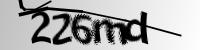

(200, 50)

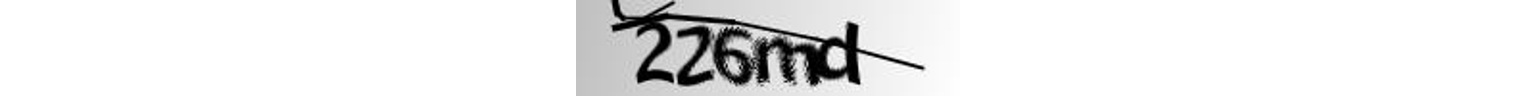

torch.Size([3, 96, 1536])

In [5]:
path_data_Captcha = path_ProjectRoot / "data/original/www.kaggle.com/code/gokulkarthik/captcha-text-recognition-using-crnn-in-pytorch/input/captcha_dataset/samples/"
list_imgPath = [file for file in path_data_Captcha.iterdir()]

imgPath = list_imgPath[0]
img = Image.open(imgPath).convert("RGB")
# img = Image.open(imagePath).convert("L")
img
img.size

img = ImageOps.pad(img, imageInputSize, color=(255, 255, 255))
# img = ImageOps.pad(img, imageInputSize, color=255)
img

toTensor = transforms.ToTensor()
imgTensor = toTensor(img).to(device)
# imgTensor
imgTensor.shape

In [6]:
list_imgPath2text_train, list_imgPath2text_test = train_test_split(list_imgPath, random_state=seedMain)
print(len(list_imgPath2text_train), len(list_imgPath2text_test))
dataset_Captcha_train = CAPTCHADataset(list_imgPath2text_train, mode_ImgRgb, imageInputSize)
dataset_Captcha_test = CAPTCHADataset(list_imgPath2text_test, mode_ImgRgb, imageInputSize)
dataloader_Captcha_train = DataLoader(dataset_Captcha_train, batch_size=batchSize, shuffle=True)
dataloader_Captcha_test = DataLoader(dataset_Captcha_test, batch_size=batchSize, shuffle=False)

802 268


### IamTextLineDataset

In [7]:
class IamTextLineDataset(Dataset):

    @staticmethod
    def parse_dict_imgPath2text(path_data_ImaTextLine_Mapping: Path, path_data_ImaTextLine_ImgRootFolder: Path):
        dict_imgPath2text: dict[Path, str] = {}

        with open(path_data_ImaTextLine_Mapping, "r") as f:
            for line in f:
                # Skip comments or blank lines
                if line.startswith("#") or line.strip() == "":
                    continue

                parts = line.strip().split()
                line_id = parts[0]  # e.g., a01-000u-00
                status = parts[1]  # e.g., ok
                text = " ".join(parts[8:]).replace("|", " ")  # Extract text, replace |

                list_LineFolderLv = line_id.split("-")

                if status == "ok":
                    image_path = path_data_ImaTextLine_ImgRootFolder / list_LineFolderLv[0] / f"{list_LineFolderLv[0]}-{list_LineFolderLv[1]}" / f"{line_id}.png"
                    dict_imgPath2text[image_path] = text  # Match img to text

        return dict_imgPath2text

    # def __init__(self, path_data_ImaTextLine_Mapping: Path, path_data_ImaTextLine_ImgRootFolder: Path):
    #     self.path_data_ImaTextLine_Mapping = path_data_ImaTextLine_Mapping
    #     self.path_data_ImaTextLine_ImgRootFolder = path_data_ImaTextLine_ImgRootFolder
    #     self.dict_imgPath2text = IamTextLineDataset.parse_dict_imgPath2text(path_data_ImaTextLine_Mapping, path_data_ImaTextLine_ImgRootFolder)
    #     self.list_imgPath2text = list(self.dict_imgPath2text.items())
    # //? order pb

    def __init__(self, list_imgPath2text: list[tuple[Path, str]], mode_ImgRgb: bool, imageInputSize: tuple[int, int]):
        self.list_imgPath2text = list_imgPath2text
        self.mode_ImgRgb = mode_ImgRgb
        self.imageInputSize = imageInputSize

    def __len__(self):
        return len(self.list_imgPath2text)

    def __getitem__(self, index: int):
        imgPath, text = self.list_imgPath2text[index]
        img = Image.open(imgPath)
        if self.mode_ImgRgb:
            img = img.convert("RGB")
        else:
            img = img.convert("L")
        imgTensor = self.transform(img)
        # filename = imgPath.stem
        return imgTensor, text

    def transform(self, img: Image.Image) -> Tensor:
        if self.mode_ImgRgb:
            img = ImageOps.pad(img, self.imageInputSize, color=(255, 255, 255))
            normalize_mean = RGB_MEAN_IMAGENET
            normalize_std = RGB_STD_IMAGENET
        else: 
            img = ImageOps.pad(img, self.imageInputSize, color=255)
            normalize_mean = BW_MEAN_IMAGENET
            normalize_std = BW_STD_IMAGENET
        transform_ops = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(mean=normalize_mean, std=normalize_std),
            ]
        )
        imgTensor = transform_ops(img)
        return imgTensor

'>> _inspect'

WindowsPath('c:/usp/usehpsj/study/textbook/DlPytorch/code/RnnLearn/04_crnnIamHwTextLine/data/original/fki.tic.heia-fr.ch/iam-handwriting-database/lines/a01/a01-000u/a01-000u-00.png')

'A MOVE to stop Mr. Gaitskell from'

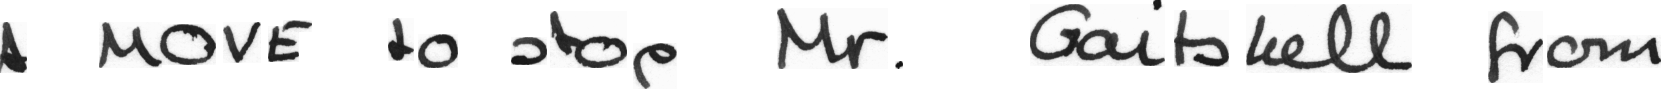

(1661, 89)

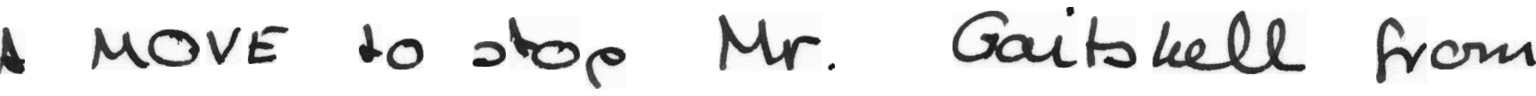

torch.Size([3, 96, 1536])

In [8]:
path_data_ImaTextLine_Mapping = path_ProjectRoot / "data/original/fki.tic.heia-fr.ch/iam-handwriting-database/ascii/lines.txt"
path_data_ImaTextLine_ImgRootFolder = path_ProjectRoot / "data/original/fki.tic.heia-fr.ch/iam-handwriting-database/lines/"

dict_imgPath2text = IamTextLineDataset.parse_dict_imgPath2text(path_data_ImaTextLine_Mapping, path_data_ImaTextLine_ImgRootFolder)
list_imgPath2text = list(dict_imgPath2text.items())


def _inspect(i: int):
    display(">> _inspect")
    imgPath, text = list_imgPath2text[i]
    display(imgPath)
    display(text)
    img = Image.open(imgPath)
    img = img.convert("RGB")
    display(img)
    display(img.size)
    img = ImageOps.pad(img, imageInputSize, color=(255, 255, 255))
    display(img)

    toTensor = transforms.ToTensor()
    imgTensor = toTensor(img).to(device)
    # imgTensor
    display(imgTensor.shape)


_inspect(0)
# _inspect(5)
# _inspect(8)

In [9]:
# turn back to dictionary if that is the structure you want:
# https://stackoverflow.com/questions/60926460/can-dictionary-data-split-into-test-and-training-set-randomly
list_imgPath2text_train, list_imgPath2text_test = train_test_split(list_imgPath2text, random_state=seedMain)
print(len(list_imgPath2text_train), len(list_imgPath2text_test))
dataset_IamTextLine_train = IamTextLineDataset(list_imgPath2text_train, mode_ImgRgb, imageInputSize)
dataset_IamTextLine_test = IamTextLineDataset(list_imgPath2text_test, mode_ImgRgb, imageInputSize)
dataloader_IamTextLine_train = DataLoader(dataset_IamTextLine_train, batch_size=batchSize, shuffle=True)
dataloader_IamTextLine_test = DataLoader(dataset_IamTextLine_test, batch_size=batchSize, shuffle=False)

8508 2836


In [10]:
def _inspect():
    imgTensor_batch: Tensor
    text_batch: tuple[str]
    imgTensor_batch, text_batch = next(iter(dataloader_Captcha_train))
    print(imgTensor_batch.size(), text_batch)  # [batch_size, channels, height, width]
    imgTensor_batch, text_batch = next(iter(dataloader_IamTextLine_train))
    print(imgTensor_batch.size(), text_batch)  # [batch_size, channels, height, width]
    # display(imgTensor_batch.isnan().any())
    # display(imgTensor_batch.isinf().any())


_inspect()

torch.Size([64, 1, 96, 1536]) ('edwny', '823p2', 'n336e', 'pybee', '244e2', 'c4bgd', '3c7de', 'nn6mg', '573d8', '243mm', '6cm6m', 'bdbb3', '5f3gf', '44c22', 'nw5b2', 'gymmn', '3p67n', 'byfgn', 'p24gn', 'ncww7', '5nm6d', 'xc68n', 'enpw2', '387g2', '8nbew', 'c8n8c', '8ypdn', 'x362g', '2b827', '4433m', 'x4f7g', 'dnne7', 'x8e8n', 'y2ye8', 'md344', '2ycn8', '5mnpd', 'nmw46', 'p8wwf', '664nf', '23n88', 'f4wfn', 'gnbde', '55y2m', 'mbf58', '74853', 'gnc3n', 'e84n2', 'ne325', 'pnmxf', 'x7547', 'w4nfx', 'ny8np', 'neecd', 'nm46n', 'cpe63', 'b43nw', 'cwdnx', '7f8b3', 'mm3nn', '3xng6', 'd22bd', 'pxne8', 'fp762')
torch.Size([64, 1, 96, 1536]) ('been much rain and damp , but the temperature is high', 'less I was a Scot and wanting to get', 'the bank is made of boys and girls aged 15', 'He was having a ball ! He twiddled the TV set with', 'and turning to the cowering Lucia , he spoke in her', 'number of disciples among unorthodox medical men in the', "' What a frightful event ! ' he wrote . ' I trembl

## 4. Define model

In [11]:
rnn_hidden_size = 256
# rnn_hidden_size = 256 * 4

In [12]:
class CRNN(nn.Module):

    def __init__(self, num_chars: int, mode_ImgRgb: bool, rnn_hidden_size=256, dropout=0.1):
        super().__init__()
        self.num_chars = num_chars
        self.rnn_hidden_size = rnn_hidden_size
        self.dropout = dropout

        # CNN Part 1
        resnet = resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)  # must put outside?.. // placing outside drops faster in first few epochs?...
        if not mode_ImgRgb:
            resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        resnet_modules = list(resnet.children())[:-3]
        self.cnn_p1 = nn.Sequential(*resnet_modules)

        # CNN Part 2
        self.cnn_p2 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=(3, 6), stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )

        # RNN
        # // feels crnn is using encoder decoder though .... just that output -- context vector passing right? dk why asked gpt before said no .... //dde
        # self.linear1 = nn.Linear(1024, 256)
        self.linear1 = nn.Linear(1536, 256)
        self.rnn1 = nn.GRU(input_size=rnn_hidden_size, hidden_size=rnn_hidden_size, bidirectional=True, batch_first=True)
        self.rnn2 = nn.GRU(input_size=rnn_hidden_size, hidden_size=rnn_hidden_size, bidirectional=True, batch_first=True)
        self.linear2 = nn.Linear(self.rnn_hidden_size * 2, num_chars)

        # #>>
        if mode_UsePretrainedWeight:
            self.dict_module_ExcludeWeightInit: dict[nn.Module, str] = dict()
            for name, module in self.cnn_p1.named_modules():
                if not mode_ImgRgb and (module == resnet.conv1):
                    continue
                self.dict_module_ExcludeWeightInit[module] = name

    def forward(self, x: Tensor):
        # print(x.size())  # @old vs @new # torch.Size([32, 3, 32, 256]) # torch.Size([32, 3, 64, 512])

        x = self.cnn_p1(x)
        # print(x.size())  # torch.Size([-1, 256, 4, 13]) # torch.Size([32, 256, 4, 32])
        # //? idk the feat extraction,
        # 1. the feature map is only of height 4, is it too small? what it extracted?
        # 1. the width of the kernel is longer than the height. what does that mean for the sequential writing of the words?

        x = self.cnn_p2(x)  # [batch_size, channels, height, width]
        # print(x.size())  # torch.Size([-1, 256, 4, 10]) # torch.Size([32, 256, 4, 29])

        x = x.permute(0, 3, 1, 2)  # [batch_size, width, channels, height]
        # print(x.size())  # torch.Size([-1, 10, 256, 4]) # torch.Size([32, 29, 256, 4])

        batch_size = x.size(0)
        T = x.size(1)
        x = x.view(batch_size, T, -1)  # [batch_size, T==width, num_features==channels*height]
        # print(x.size())  # torch.Size([-1, 10, 1024]) # torch.Size([32, 29, 1024])

        x = self.linear1(x)
        # # print(x.size())  # torch.Size([-1, 10, 256]) # torch.Size([32, 29, 256])

        x, hidden = self.rnn1(x)
        feature_size = x.size(2)
        x = x[:, :, : feature_size // 2] + x[:, :, feature_size // 2 :]
        # print(x.size())  # torch.Size([-1, 10, 256]) # torch.Size([32, 29, 256])

        x, hidden = self.rnn2(x)
        # print(x.size())  # torch.Size([-1, 10, 512]) # torch.Size([32, 29, 512])

        x = self.linear2(x)
        # print(x.size())  # torch.Size([-1, 10, 20]) # torch.Size([32, 29, 95])

        x = x.permute(1, 0, 2)  # [T==10, batch_size, num_classes==num_features]
        # print(x.size())  # torch.Size([10, -1, 20]) # torch.Size([29, 32, 95])

        return x

    def weights_init(self, module: nn.Module):
        if mode_UsePretrainedWeight:
            moduleName_Exclude = self.dict_module_ExcludeWeightInit.get(module)
            if moduleName_Exclude is not None:
                # print(f"{moduleName_Exclude:<20} {module._get_name():<20} << This is in the pretrained Resnet:")
                return
            else:
                # print(f"{'':<20} {module._get_name():<20}")
                pass

        if isinstance(module, (nn.Linear, nn.Conv2d, nn.Conv1d)):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.fill_(0.01)
        elif isinstance(module, (nn.BatchNorm2d, nn.BatchNorm1d)):
            module.weight.data.normal_(1.0, 0.02)
            module.bias.data.fill_(0)

In [13]:
# Building a Captcha OCR in TF2.0
# https://www.kaggle.com/code/aakashnain/building-a-captcha-ocr-in-tf2-0
# 
# CAPTCHA : 2 solutions to break them [>99%]
# https://www.kaggle.com/code/arnrob/captcha-2-solutions-to-break-them-99#Model-Performance
# 
# Handwritten Text Recognition-IAM
# https://www.kaggle.com/code/hamiddamadi/handwritten-text-recognition-iam/notebook#Building-the-Handwritten-Text-Recognition-Model-(HTR)
# 
# class CRNN(nn.Module):
# 
#     def __init__(self, num_chars, rnn_hidden_size=256, dropout=0.2):
#         super().__init__()
#         self.num_chars = num_chars
#         self.rnn_hidden_size = rnn_hidden_size
#         self.dropout = dropout
# 
#         # CNN Part 1
#         self.cnn_p1 = nn.Sequential(
#             nn.Conv2d(1, 32, kernel_size=(3, 3), stride=1, padding=1),
#             # nn.BatchNorm2d(32),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=(2, 2)),  # // dkdkdkdk padding
#         )
# 
#         # CNN Part 2
#         self.cnn_p2 = nn.Sequential(
#             nn.Conv2d(32, 64, kernel_size=(3, 3), stride=1, padding=1),
#             # nn.BatchNorm2d(64),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=(2, 2)),
#         )
# 
#         # RNN
#         self.linear1 = nn.Linear(768, 64)  # 50 (height after pooling), 768 total width reduced to 64.
# 
#         # RNN layers
#         self.rnn1 = nn.LSTM(input_size=64, hidden_size=128, bidirectional=True, batch_first=True, dropout=0.25)
#         self.rnn2 = nn.LSTM(input_size=128*2, hidden_size=64, bidirectional=True, batch_first=True, dropout=0.25)
# 
#         self.linear2 = nn.Linear(64 * 2, num_chars)
# 
#     def forward(self, x: Tensor):
#         # print(x.size())  # @old vs @new # torch.Size([32, 3, 32, 256]) ###
#         x = self.cnn_p1(x)
#         # print(x.size())  # torch.Size([-1, 256, 4, 13]) ###
#         x = self.cnn_p2(x)  # [batch_size, channels, height, width]
#         # print(x.size())  # torch.Size([-1, 256, 4, 10]) ###
# 
#         # print('linear')
#         x = x.permute(0, 3, 1, 2)  # [batch_size, width, channels, height]
#         # print(x.size())  # torch.Size([-1, 10, 256, 4]) ###
#         batch_size = x.size(0)
#         T = x.size(1)
#         x = x.view(batch_size, T, -1)  # [batch_size, T==width, num_features==channels*height]
#         # print(x.size())  # torch.Size([-1, 10, 1024]) ###
# 
#         x = self.linear1(x)
#         x = F.relu(x)
#         x = F.dropout(x, self.dropout)
#         # print(x.size())  # torch.Size([-1, 10, 256]) ###
# 
#         # print('rnn')
#         x, hidden = self.rnn1(x)
#         feature_size = x.size(2)
#         # x = x[:, :, : feature_size // 2] + x[:, :, feature_size // 2 :]
#         # print(x.size())  # torch.Size([-1, 10, 256]) ###
# 
#         x, hidden = self.rnn2(x)
#         # print(x.size())  # torch.Size([-1, 10, 512]) ###
# 
#         x = self.linear2(x)
#         # print(x.size())  # torch.Size([-1, 10, 20]) ###
# 
#         x = x.permute(1, 0, 2)  # [T==10, batch_size, num_classes==num_features]
#         # print(x.size())  # torch.Size([10, -1, 20]) ###
# 
#         return x

In [14]:
def _inspect():
    imgTensor_batch: Tensor
    text_batch: tuple[str]
    imgTensor_batch, text_batch = next(iter(dataloader_Captcha_train))

    # #>>> check shape
    
    # resnet = resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
    # out: Tensor = resnet(imgTensor_batch)
    # out.shape

    crnn = CRNN(num_chars, mode_ImgRgb, rnn_hidden_size=rnn_hidden_size)
    out = crnn(imgTensor_batch) # @slow // directly call forward is not faster...
    display(out.shape)

    # #>>> 
    del crnn

# _inspect()

In [15]:
# def weights_init(m: nn.Linear | nn.Conv2d | nn.Conv1d | nn.BatchNorm2d | nn.BatchNorm1d | nn.Module):
#     classname = m.__class__.__name__
#     print(f"name: {m._get_name()}")
#     print(type(m))
#     print(classname)
#     if isinstance(m, nn.Sequential):
#         print("SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS")
#     for cls in (nn.Linear, nn.Conv2d, nn.Conv1d, nn.BatchNorm2d, nn.BatchNorm1d):
#         print(isinstance(m, cls), end="; ")
#     print()
#     if type(m) in [nn.Linear, nn.Conv2d, nn.Conv1d]:
#         torch.nn.init.xavier_uniform_(m.weight)
#         if m.bias is not None:
#             m.bias.data.fill_(0.01)
#     elif classname.find("BatchNorm") != -1:
#         m.weight.data.normal_(1.0, 0.02)
#         m.bias.data.fill_(0)

In [16]:
def _inspect():
    crnn = CRNN(num_chars, mode_ImgRgb, rnn_hidden_size=rnn_hidden_size)
    display(crnn)

    # #>>> check param & weight

    # #>>>
    # for name, module in crnn.cnn_p1.named_children():
    #     print(name, module)
    resnet = resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
    # display(resnet)

    amountParam = 0
    dict_weight_Before = {}
    for name, param in crnn.named_parameters():
        dict_weight_Before[name] = param.clone()
        amountParam += param.numel()
    # display(dict_weight_Before.keys())

    # #>>>
    # display(sum(p.numel() for p in crnn.parameters()))
    display(amountParam)

    # #>>>
    #
    # ;[another layer]; dict_weight_Before_WaysToAccess: dict[str, Tensor] = {}
    # ;[another layer]; dict_weight_Before_WaysToAccess['dict_weight_Before["cnn_p1.0.weight"]'] = dict_weight_Before["cnn_p1.0.weight"]
    # ;[another layer]; dict_weight_Before_WaysToAccess["crnn.cnn_p1[0].weight.clone()"] = crnn.cnn_p1[0].weight.clone()
    # ;[another layer]; dict_weight_Before_WaysToAccess["resnet.conv1.weight.clone()"] = resnet.conv1.weight.clone() # deps on mode_ImgRgb ...
    #
    # (layer1): Sequential(     (0): BasicBlock(       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    list_weight_Before_WaysToAccess = [
        dict_weight_Before["cnn_p1.4.0.conv1.weight"],
        crnn.cnn_p1[4][0].conv1.weight.clone(),
        resnet.layer1[0].conv1.weight.clone(),
    ]
    display(all(torch.equal(list_weight_Before_WaysToAccess[0], t) for t in list_weight_Before_WaysToAccess[1:]))

    # #>>>
    _ = crnn.apply(crnn.weights_init)
    dict_weight_After = {name: param.clone() for name, param in crnn.named_parameters()}

    # (dict_weight_Before["cnn_p2.0.weight"], dict_weight_After["cnn_p2.0.weight"])
    if torch.equal(dict_weight_Before["cnn_p2.0.weight"], dict_weight_After["cnn_p2.0.weight"]):
        raise ValueError("After weight inited, it should be diff.")

    if torch.equal(dict_weight_Before["cnn_p1.4.0.conv1.weight"], dict_weight_After["cnn_p1.4.0.conv1.weight"]):
        print("crnn.apply(weights_init) does not overwrite the resnet pretrained weight.")
    else:
        print("crnn.apply(weights_init) does overwrite the resnet pretrained weight.")

    # #>>>
    del crnn

_inspect()

CRNN(
  (cnn_p1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

5978656

True

crnn.apply(weights_init) does not overwrite the resnet pretrained weight.


In [17]:
crnn = CRNN(num_chars, mode_ImgRgb, rnn_hidden_size=rnn_hidden_size)
_ = crnn.apply(crnn.weights_init)
crnn = crnn.to(device)
# crnn

## 5. Define loss

In [18]:
criterion = nn.CTCLoss(blank=0)

In [19]:
def encode_ctc_target_text_batch(target_text_batch: tuple[str]):
    target_text_batch_length = [len(text) for text in target_text_batch]
    target_text_batch_length = torch.IntTensor(target_text_batch_length).to(device)

    target_text_batch_concat = "".join(target_text_batch)
    target_textTensor_batch_concat = [char2idx[c] for c in target_text_batch_concat]
    target_textTensor_batch_concat = torch.IntTensor(target_textTensor_batch_concat).to(device)
    return target_textTensor_batch_concat, target_text_batch_length


def compute_ctcLoss(criterion: nn.CTCLoss, target_text_batch: tuple[str], predRnnSeqOutDistLogit_text_batch: Tensor):
    """
    target_text_batch: list of strings of length equal to batch size
    predRnnSeqOutDistLogit_text_batch: Tensor of size([rnnSeqLength, batch_size, num_classes])
    """
    predRnnSeqOutDistProb_text_batch = F.log_softmax(predRnnSeqOutDistLogit_text_batch, 2)  # [T, batch_size, num_classes]
    predRnnSeqOutDistProb_text_batch_length = torch.full(size=(predRnnSeqOutDistProb_text_batch.size(1),), fill_value=predRnnSeqOutDistProb_text_batch.size(0), dtype=torch.int32).to(
        device
    )  # [batch_size]
    target_textTensor_batch_concat, target_text_batch_length = encode_ctc_target_text_batch(target_text_batch)
    loss = criterion(predRnnSeqOutDistProb_text_batch, target_textTensor_batch_concat, predRnnSeqOutDistProb_text_batch_length, target_text_batch_length)

    return loss

## 6. Train model

In [20]:
# num_epochs = 50
num_epochs = 6
lr = 0.001
# lr = 0.008
# lr = 0.004
# lr = 1e-4
weight_decay = 1e-3
clip_norm = 5

In [21]:
optimizer = optim.Adam(crnn.parameters(), lr=lr, weight_decay=weight_decay)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5)  # , verbose=True

In [22]:
# dataloader_train = dataloader_Captcha_train
dataloader_train = dataloader_IamTextLine_train

list_epochLoss: list[np.float64] = []
listEpoch_listBatch_iterLoss: list[list[float]] = []
listEpoch_listBatch_time: list[list[float]] = []
# snSample = 0


def train(num_epochs: int, dataloader_train: DataLoader, optimizer: optim.Optimizer, lr_scheduler: optim.lr_scheduler.ReduceLROnPlateau):
    timeTrainStart = datetime.now().strftime("%Y_%m%d_%H%M_%S")
    timeLastModelSave = time.time()
    for epoch in tqdm(range(1, num_epochs + 1)):
        listBatch_iterLoss: list[float] = []
        amountOfUpdatesPerEpoch = 0
        listBatch_time = [time.time()]
        idxBatch = -1
        for imgTensor_batch, target_text_batch in tqdm(dataloader_train, leave=False):
            idxBatch += 1
            # snSample += len(imgTensor_batch)

            predRnnSeqOutDistLogit_text_batch: Tensor = crnn(imgTensor_batch.to(device))
            loss: Tensor = compute_ctcLoss(criterion, target_text_batch, predRnnSeqOutDistLogit_text_batch)
            iterLoss = loss.item()

            # //? why, not differentiable?
            if np.isnan(iterLoss) or np.isinf(iterLoss):
                continue

            amountOfUpdatesPerEpoch += 1
            listBatch_iterLoss.append(iterLoss)
            optimizer.zero_grad()
            loss.backward()
            _ = nn.utils.clip_grad_norm_(crnn.parameters(), clip_norm)  # gradient clipping?..
            optimizer.step()

            if idxBatch % 64 == 0:
                listBatch_time.append(time.time())
                print(f"Epoch: {epoch:03d}    Batch: {idxBatch:03d}    TimeFromBatchStart: {listBatch_time[-1] - listBatch_time[0]:6.3f}   iterLoss: {iterLoss:10.6f}")

        epochLoss = np.mean(listBatch_iterLoss)
        list_epochLoss.append(epochLoss)
        lr_scheduler.step(epochLoss)
        listEpoch_listBatch_iterLoss.append(listBatch_iterLoss)
        listEpoch_listBatch_time.append(listBatch_time)
        timeEpochEnd = time.time()
        print(f"Epoch: {epoch:03d}    TimeFromEpochStart: {timeEpochEnd - listBatch_time[0]:6.3f}   epochLoss: {epochLoss:10.6f}")

        if (timeEpochEnd - timeLastModelSave > 600) or (epoch == num_epochs):
            torch.save(
                {
                    "epoch": epoch,
                    "model_state_dict": crnn.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "scheduler_state_dict": lr_scheduler.state_dict(),
                    "loss": epochLoss,
                },
                path_ProjectRoot / (f"model/crnn - iamTextLine - {timeTrainStart} epoch{epoch}.pth"),
            )
            timeLastModelSave = timeEpochEnd


train(num_epochs, dataloader_train, optimizer, lr_scheduler)

print(f"TimeSpanAllEpoch: {listEpoch_listBatch_time[-1][-1] - listEpoch_listBatch_time[0][0]}")

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

Epoch: 001    Batch: 000    TimeFromBatchStart:  5.612   iterLoss:   8.304913
Epoch: 001    Batch: 064    TimeFromBatchStart: 124.029   iterLoss:   3.289974
Epoch: 001    Batch: 128    TimeFromBatchStart: 248.299   iterLoss:   3.097017
Epoch: 001    TimeSpanPerBatch: 248.299   epochLoss:   3.427219


  0%|          | 0/133 [00:00<?, ?it/s]

Epoch: 002    Batch: 000    TimeFromBatchStart:  1.987   iterLoss:   3.121568
Epoch: 002    Batch: 064    TimeFromBatchStart: 120.716   iterLoss:   2.818743
Epoch: 002    Batch: 128    TimeFromBatchStart: 239.063   iterLoss:   1.687984
Epoch: 002    TimeSpanPerBatch: 239.063   epochLoss:   2.585196


  0%|          | 0/133 [00:00<?, ?it/s]

Epoch: 003    Batch: 000    TimeFromBatchStart:  2.003   iterLoss:   1.590640
Epoch: 003    Batch: 064    TimeFromBatchStart: 121.261   iterLoss:   1.034592
Epoch: 003    Batch: 128    TimeFromBatchStart: 238.339   iterLoss:   0.792773
Epoch: 003    TimeSpanPerBatch: 238.339   epochLoss:   1.060116


  0%|          | 0/133 [00:00<?, ?it/s]

Epoch: 004    Batch: 000    TimeFromBatchStart:  2.006   iterLoss:   0.705022
Epoch: 004    Batch: 064    TimeFromBatchStart: 120.477   iterLoss:   0.620334
Epoch: 004    Batch: 128    TimeFromBatchStart: 239.407   iterLoss:   0.608664
Epoch: 004    TimeSpanPerBatch: 239.407   epochLoss:   0.625273


  0%|          | 0/133 [00:00<?, ?it/s]

Epoch: 005    Batch: 000    TimeFromBatchStart:  2.010   iterLoss:   0.451651
Epoch: 005    Batch: 064    TimeFromBatchStart: 120.081   iterLoss:   0.561081
Epoch: 005    Batch: 128    TimeFromBatchStart: 239.133   iterLoss:   0.512672
Epoch: 005    TimeSpanPerBatch: 239.133   epochLoss:   0.503534


  0%|          | 0/133 [00:00<?, ?it/s]

Epoch: 006    Batch: 000    TimeFromBatchStart:  2.044   iterLoss:   0.340870
Epoch: 006    Batch: 064    TimeFromBatchStart: 118.949   iterLoss:   0.335771
Epoch: 006    Batch: 128    TimeFromBatchStart: 251.086   iterLoss:   0.426037
Epoch: 006    TimeSpanPerBatch: 251.086   epochLoss:   0.436872
TimeSpanAllEpoch: 1492.41388297081


In [32]:
# px.line(x=list(range(1, len(list_epochLoss) + 1)), y=list_epochLoss, labels={"x": "Epoch", "y": "Loss"}, markers=True)
# px.line(listEpoch_listBatch_iterLoss)
# px.line(listEpoch_listBatch_time)

# Epoch: 001    Batch: 000    TimeFromBatchStart:  5.612   iterLoss:   8.304913
# Epoch: 001    Batch: 064    TimeFromBatchStart: 124.029   iterLoss:   3.289974
# Epoch: 001    Batch: 128    TimeFromBatchStart: 248.299   iterLoss:   3.097017
# Epoch: 001    TimeSpanPerBatch: 248.299   epochLoss:   3.427219
# Epoch: 002    Batch: 000    TimeFromBatchStart:  1.987   iterLoss:   3.121568
# Epoch: 002    Batch: 064    TimeFromBatchStart: 120.716   iterLoss:   2.818743
# Epoch: 002    Batch: 128    TimeFromBatchStart: 239.063   iterLoss:   1.687984
# Epoch: 002    TimeSpanPerBatch: 239.063   epochLoss:   2.585196
# Epoch: 003    Batch: 000    TimeFromBatchStart:  2.003   iterLoss:   1.590640
# Epoch: 003    Batch: 064    TimeFromBatchStart: 121.261   iterLoss:   1.034592
# Epoch: 003    Batch: 128    TimeFromBatchStart: 238.339   iterLoss:   0.792773
# Epoch: 003    TimeSpanPerBatch: 238.339   epochLoss:   1.060116
# Epoch: 004    Batch: 000    TimeFromBatchStart:  2.006   iterLoss:   0.705022
# Epoch: 004    Batch: 064    TimeFromBatchStart: 120.477   iterLoss:   0.620334
# Epoch: 004    Batch: 128    TimeFromBatchStart: 239.407   iterLoss:   0.608664
# Epoch: 004    TimeSpanPerBatch: 239.407   epochLoss:   0.625273
# Epoch: 005    Batch: 000    TimeFromBatchStart:  2.010   iterLoss:   0.451651
# Epoch: 005    Batch: 064    TimeFromBatchStart: 120.081   iterLoss:   0.561081
# Epoch: 005    Batch: 128    TimeFromBatchStart: 239.133   iterLoss:   0.512672
# Epoch: 005    TimeSpanPerBatch: 239.133   epochLoss:   0.503534
# Epoch: 006    Batch: 000    TimeFromBatchStart:  2.044   iterLoss:   0.340870
# Epoch: 006    Batch: 064    TimeFromBatchStart: 118.949   iterLoss:   0.335771
# Epoch: 006    Batch: 128    TimeFromBatchStart: 251.086   iterLoss:   0.426037
# Epoch: 006    TimeSpanPerBatch: 251.086   epochLoss:   0.436872
# TimeSpanAllEpoch: 1492.41388297081

In [24]:
# torch.save(crnn.state_dict(), path_ProjectRoot / ("model/crnn - captcha - " + datetime.now().strftime("%Y_%m%d_%H%M_%S%f") + ".pth"))

In [25]:
# crnn = CRNN(num_chars, rnn_hidden_size=rnn_hidden_size)
# crnnWeight = torch.load("C:/usp/usehpsj/study/textbook/DlPytorch/code/RnnLearn/03_crnn/model/crnn - 2024_1209_0515_56206687.pth")
# _ = crnn.load_state_dict(crnnWeight)
# crnn = crnn.to(device)

## 7. Make predictions

In [26]:
def convert_textRnn2textRepeat(predRnnSeqOutDistLogit_text_batch: Tensor) -> list[str]:
    text_batch_tokens = F.softmax(predRnnSeqOutDistLogit_text_batch, 2).argmax(2) # [T, batch_size]
    text_batch_tokens = text_batch_tokens.numpy().T # [batch_size, T]

    text_batch_tokens_new = []
    for text_tokens in text_batch_tokens:
        text = [idx2char[idx] for idx in text_tokens]
        text = "".join(text)
        text_batch_tokens_new.append(text)

    return text_batch_tokens_new

def remove_duplicates(text):
    if len(text) > 1:
        letters = [text[0]] + [letter for idx, letter in enumerate(text[1:], start=1) if text[idx] != text[idx-1]]
    elif len(text) == 1:
        letters = [text[0]]
    else:
        return ""
    return "".join(letters)

def convert_textRepeat2text(word: str):
    parts = word.split(ctcBlankChar)
    parts = [remove_duplicates(part) for part in parts]
    corrected_word = "".join(parts)
    return corrected_word

In [33]:
def pred(dataset: Dataset):
    df_TargetVsPred = pd.DataFrame(columns=["target", "pred", "predRepeat"])
    dataloader = DataLoader(dataset, batch_size=16, shuffle=False)
    list_target_text = []
    list_pred_text_batch_Repeat = []
    list_pred_text_batch = []
    with torch.no_grad():
        for imgTensor_batch, target_text_batch in tqdm(dataloader, leave=True):
            predRnnSeqOutDistLogit_text_batch = crnn(imgTensor_batch.to(device))  # [T, batch_size, num_classes==num_features]
            pred_text_batch_Repeat = convert_textRnn2textRepeat(predRnnSeqOutDistLogit_text_batch.cpu())
            list_target_text = list_target_text + list(target_text_batch)
            list_pred_text_batch_Repeat += pred_text_batch_Repeat
            list_pred_text_batch += [convert_textRepeat2text(text) for text in pred_text_batch_Repeat]
    df_TargetVsPred["target"] = list_target_text fD
    df_TargetVsPred["pred"] = list_pred_text_batch
    df_TargetVsPred["predRepeat"] = list_pred_text_batch_Repeat
    return df_TargetVsPred


df_TargetVsPred_train = pred(dataset_IamTextLine_train)
df_TargetVsPred_test = pred(dataset_IamTextLine_test)
display(df_TargetVsPred_train)
display(df_TargetVsPred_test)
train_accuracy = accuracy_score(df_TargetVsPred_train["target"], df_TargetVsPred_train["pred"])
test_accuracy = accuracy_score(df_TargetVsPred_test["target"], df_TargetVsPred_test["pred"])
print(train_accuracy)
print(test_accuracy)

  0%|          | 0/532 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

target  \
0     and her luggage had disappeared and they were ...   
1                 and this matched reasonably well with   
2       largest firms and about 23 per cent by the next   
3      submariners . You ought to have married that fat   
4                      began to understand the value of   
...                                                 ...   
8503               flat with a devotion which said that   
8504     always been strong in mankind . The sharing of   
8505  sole , a baked leg of mutton with oyster & vea...   
8506      illusion in the Conservative Party that their   
8507         suitable to be paraded before the public !   

                                                   pred  \
0     an■d■  h■eer■  lu■g■p■a■ge■   h■a■d  ddis■ap■p...   
1     ■■■■■■o■n■■dd  tthhiiss  ■n■■■a■■te■h■ee■d■  r...   
2     ■■■■■■■■■la■■gestt  fiir■nss  ■a■n■d a■b■o■u■■...   
3     ■■■■S■u■b■■m■■a■rin■er■s .. Yo■u■  o■u■g■h■tt ...   
4     ■■■■■■■■■■■■■■be■gga■n■  ttoo  u■n■■d■s■rs■t■a...   
...                                                 ...   
8503  fl■a■■t■   ■w■■i■t■h■■  ■a■■  ■ddee■w■■oo■t■i■...   
8504  ■■■■■■■■■■■■al■r■ay■■   te■ee sst■on■g  inn  ■...   
8505  ■■■■■■■■■■■■■n■dlee , n batedd ly■of  mantt  i...   
8506  ■■■■il■llastoon■   t■n  thhee■■   C■o■■s■e■r■v...   
8507  ■■■ssu■■i■t■a■■b■le■    t■o■  b■ee  ■p■a■rra■■...   

                                             predRepeat  
0     and her lugpage had disappeared and they were ...  
1                 ond this natehed reasenably well with  
2         lagest firns and about1Bper, cont by the next  
3      Submariners . You ought to have married that fat  
4                      began to undsrstand the value of  
...                                                 ...  
8503               flat with a dewotian which said that  
8504        alray tee stong in manhind - The sharing of  
8505  ndle , n bated lyof mant ith ooter real selfig...  
8506       illaston tn the Coservative Party that their  
8507         suitable to be paraded befer the public !   

[8508 rows x 3 columns]

target  \
0     and Haris there were many events . Chief of th...   
1               adjust the financing - which Mr. Powell   
2        right to blame the politicians unless they see   
3     from the dissection of living animals , showin...   
4               Nationalists and 20 United party candi-   
...                                                 ...   
2831  All four were Conservative strongholds . Last ...   
2832      someone to love you while you are looking for   
2833           appearance of the Progressive party from   
2834  BRITAIN - One cannot but wonder at British bas...   
2835  21 daughter . When the second stage ( the bismuth   

                                                   pred  \
0     an■d■  ■M■ar■is■  thh■er■e■  w■eer■e  m■■a■n■y...   
1     ad■jju■s■t■■   ■thh■e■■  f■i■n■a■n■■■c■i■n■■g■...   
2     ighhtt  ■t■o■  ■bl■a■m■■ee■   t■h■e■■   p■olii...   
3     ■■■■■■■■■■■■t■om tthe dissedion of hhnigg anin...   
4     w■a■ti■o■n■a■t■i■sts■■   ■a■n■■d■■■  ■s■o■■   ...   
...                                                 ...   
2831  al■l■  ■f■ou■r■   ■w■eree   C■ou■ser■vaatiivee...   
2832  ■■■■■■s■■m■e■o■n■e■  ■to■  lo■vee  y■ou■  ■w■h...   
2833  ap■pee■a■r■a■n■■cen■■   o■■f   t■h■■e■■■■    P...   
2834  sxl■T■Ah■■w■ -■■■d■u■■e  ■ca■n■a■ot■   b■u■t■ ...   
2835  ad■  ■d■a■n■ggh■■t■eer .  W■■h■e■n■  tthe■■  s...   

                                             predRepeat  
0     and Maris there were many esents . Chief of th...  
1               adjust the financing - which Mr . Poweh  
2         ight to blame the politicians uuless they see  
3     tom the disedion of hnig aninas , horing how t...  
4                wationatists and so hrited paty condi-  
...                                                 ...  
2831  all four were Couservative strongholds . hast ...  
2832        smeone to love you whil you are lookeng for  
2833          appearancen of the Progrersive porty fron  
2834  sxlTAhw -due canaot but wnde at suilish baven biy  
2835   ad danghter . When the second stagel the bismunt  

[2836 rows x 3 columns]

0.0
0.0


In [29]:
df_Mistake = df_TargetVsPred_test[df_TargetVsPred_test['target'] != df_TargetVsPred_test['pred']]
df_Mistake

target  \
0     and Haris there were many events . Chief of th...   
1               adjust the financing - which Mr. Powell   
2        right to blame the politicians unless they see   
3     from the dissection of living animals , showin...   
4               Nationalists and 20 United party candi-   
...                                                 ...   
2831  All four were Conservative strongholds . Last ...   
2832      someone to love you while you are looking for   
2833           appearance of the Progressive party from   
2834  BRITAIN - One cannot but wonder at British bas...   
2835  21 daughter . When the second stage ( the bismuth   

                                                   pred  \
0     an■d■  ■M■ar■is■  thh■er■e■  w■eer■e  m■■a■n■y...   
1     ad■jju■s■t■■   ■thh■e■■  f■i■n■a■n■■■c■i■n■■g■...   
2     ighhtt  ■t■o■  ■bl■a■m■■ee■   t■h■e■■   p■olii...   
3     ■■■■■■■■■■■■t■om tthe dissedion of hhnigg anin...   
4     w■a■ti■o■n■a■t■i■sts■■   ■a■n■■d■■■  ■s■o■■   ...   
...                                                 ...   
2831  al■l■  ■f■ou■r■   ■w■eree   C■ou■ser■vaatiivee...   
2832  ■■■■■■s■■m■e■o■n■e■  ■to■  lo■vee  y■ou■  ■w■h...   
2833  ap■pee■a■r■a■n■■cen■■   o■■f   t■h■■e■■■■    P...   
2834  sxl■T■Ah■■w■ -■■■d■u■■e  ■ca■n■a■ot■   b■u■t■ ...   
2835  ad■  ■d■a■n■ggh■■t■eer .  W■■h■e■n■  tthe■■  s...   

                                             predRepeat  
0     and Maris there were many esents . Chief of th...  
1               adjust the financing - which Mr . Poweh  
2         ight to blame the politicians uuless they see  
3     tom the disedion of hnig aninas , horing how t...  
4                wationatists and so hrited paty condi-  
...                                                 ...  
2831  all four were Couservative strongholds . hast ...  
2832        smeone to love you whil you are lookeng for  
2833          appearancen of the Progrersive porty fron  
2834  sxlTAhw -due canaot but wnde at suilish baven biy  
2835   ad danghter . When the second stagel the bismunt  

[2836 rows x 3 columns]

In [30]:
# data_path = path_data_Captcha
# Image.open(mistake_image_fp)